Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Anjana Tissera"
ID = "123459"

---

# Lab 12: Gaussian Mixture Models (GMMs)

In lecture, we learned that the Gaussian Mixture Model (GMM) is a more sophisticated unsupervised clustering method than
$k$-means.

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [4]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [5]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.184      0.20558199 0.61041801]
[0.2, 0.2, 0.6]
5.695072063343341e-05


In [6]:
print(Mu)
print(np.array(means_gt).T)

[[ 1.09973683  9.71779897  9.90822916]
 [ 9.880927    0.87733694 10.07849726]]
[[ 1 10 10]
 [10  1 10]]


In [7]:
print(Sigma)
print(sigmas_gt)

[[[ 0.96874889 -0.14242794]
  [-0.14242794  0.97623482]]

 [[ 3.18390928  0.02833734]
  [ 0.02833734  0.99977735]]

 [[ 0.99100633  0.0751997 ]
  [ 0.0751997   4.37029775]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning
of the experiment. Report your results and briefly discuss in your lab report.

Next, we continue to find outliers:

In [8]:
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print("Min. MSE between estimated Phi and ground trouth Phi: ", phi_mse)

mu_mse = np.mean(np.min((Mu-np.array(means_gt).T)**2,axis=1))
print("Min. MSE between estimated Mu and ground trouth Mu: ", mu_mse)

migma_mse = np.mean(np.min((Sigma-sigmas_gt)**2,axis=1))
print("Min. MSE between estimated Sigma and ground trouth Sigma: ", migma_mse)

Min. MSE between estimated Phi and ground trouth Phi:  5.695072063343341e-05
Min. MSE between estimated Mu and ground trouth Mu:  0.007291853650870755
Min. MSE between estimated Sigma and ground trouth Sigma:  0.001346725257680939


### Answer:

- From the calculation above, we can see that when we calculate the minimum MSE between the estimated parameters Phi, Mu, and Sigma and the ground truth values set up at the beginning of the experiment, they are small values. Especially the minimum MSE between ground truth Prior probability (phi_j) for each cluster and estimated Phi is very insignificant.

- Thus we can conclude that the estimated values Phi, Mu, and Sigma are very close to the ground truth.


In [9]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

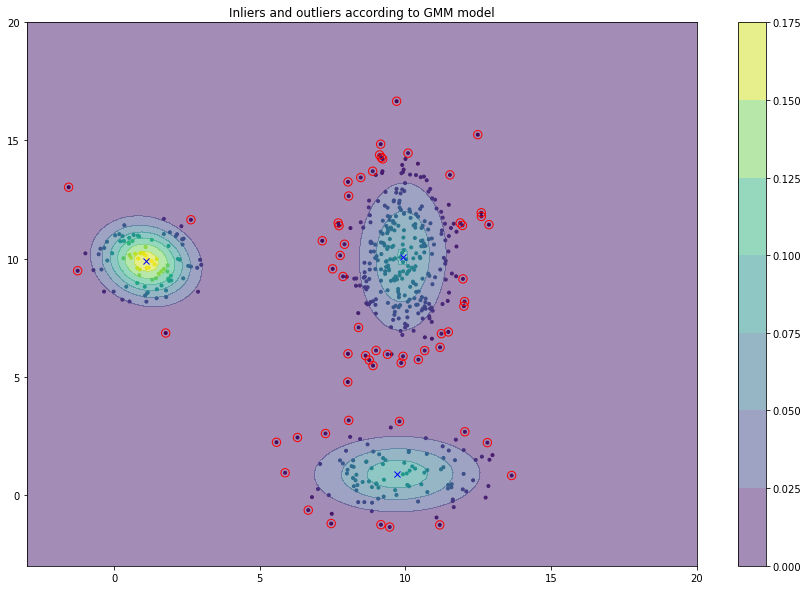

In [10]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, understand why, and explain in your report.  Second, read about Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain in your report. 

In [11]:
# You may need code to explain

YOUR ANSWER HERE

### Answer:

 - Broader clusters has a higher varience. This results in lowering the higght of the normal curve and making the spread of its tails wider. This results in a lower threshold for a particular p value increasing the number of outliers.

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis (5 points)

YOUR ANSWER HERE

### Answer:

- Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. 
- It is an extremely useful metric having, excellent applications in multivariate anomaly detection, classification on highly imbalanced datasets

#### Write code Mahalanobis (10 points)

In [12]:
temp1= X[1,:]
temp2 = (temp1 - Mu[:,1]).reshape(-1,1)
temp2.shape, Mu[:,1].shape

((2, 1), (2,))

In [13]:
import sys
from scipy.stats import chi2
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = None
        # get target sigma
        sig = None
        # inverse matrix of sigma
        sig_inv = None
        # find difference of mu and x and reshape it (if need)
        diff = None
        # calculate distance from diff and sigma
        distance = None
        # YOUR CODE HERE
        mu = Mu[:,kk]
        sig = Sigma[kk]
        sig_inv = np.linalg.inv(sig)
        diff = (x - mu).reshape(-1,1)
        distance1 = np.dot(diff.T, sig_inv)
        distance2 = np.dot(distance1, diff)      
        distance = np.sqrt(distance2)
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
k_idx = np.argmin(m_distance,axis=1)
(unique, counts) = np.unique(k_idx, return_counts=True)


max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = None
# find outlier from min_distance
outlier = None
# YOUR CODE HERE
min_distance = np.min(m_distance, axis=1)
outlier =  (min_distance > max_z_score)


(3, 2, 2)
(2, 3)
(500, 2)


outlier [False False  True False False False False False False False  True False
 False False False False False False  True False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False  True False  True False False
  True False False False False  True  True False False  True False False
  True False False False False False False False  True False False False
 False False False False False False False False False False False False
  True False False  True False False False False False False  True False
  True False  True False  True False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False 

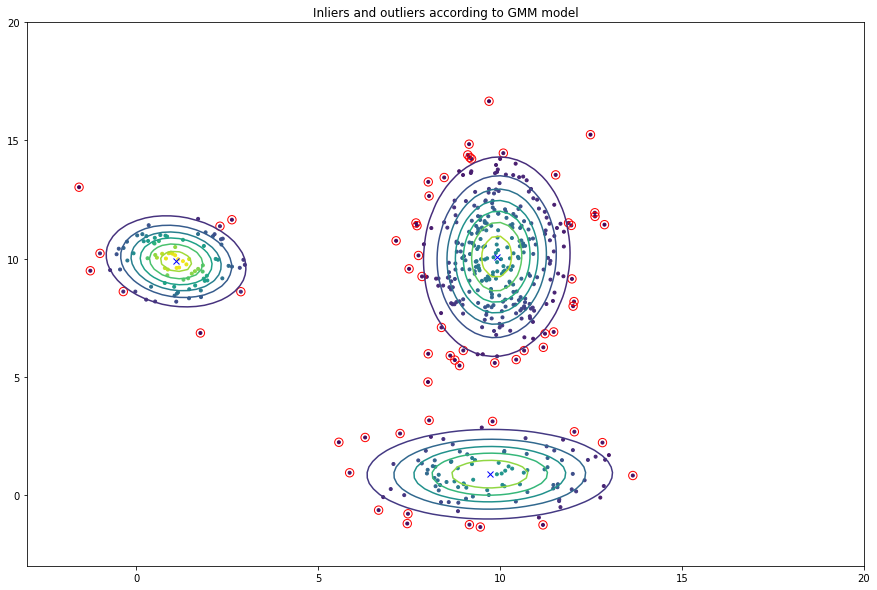

success!


In [14]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation
from last week dataset [Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Let's stick to just two dimensions in the dataset:

In [15]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [16]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [17]:
print(Mu)

[[60.96636029 89.8152026  48.76608998]
 [55.95012326 14.9613277  56.25559989]]


The first row represents annual income, whereas the second row represents the spending score. From what i noticed, these values changes in every iteration, and therefore it is difficult segregate this data into 3 categories.

In [18]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

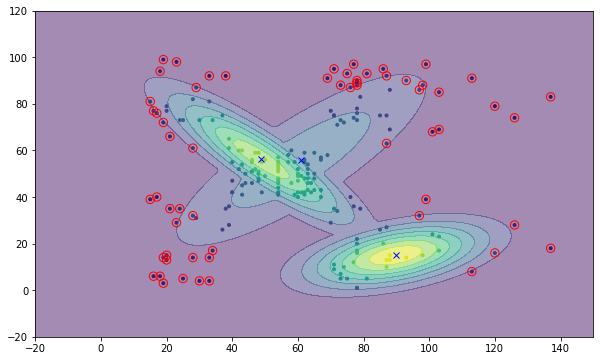

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to last week's results with k-means. (20 points)

#### Discussion report (5 points)

YOUR ANSWER HERE

### Answer:

In [20]:
Mu.T

array([[60.96636029, 55.95012326],
       [89.8152026 , 14.9613277 ],
       [48.76608998, 56.25559989]])

#### Interpretation of Clusters:
- Cluster 1: Average Annual Income, Average Spending Score
- Cluster 2: High Annual Income , low Spending Score
- Cluster3: Low Annual Income, High Spending Score

#### Do k-mean and compare the result

In [21]:
# YOUR CODE HERE
import torch
from kmeans_pytorch import kmeans
x =  torch.from_numpy(X)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device: ", device)
labels, means = kmeans(X=x, num_clusters=3, distance='euclidean', device=torch.device(device))
data["label"] = labels

Device:  cuda:0
running k-means on cuda:0..


[running kmeans]: 8it [00:00, 546.63it/s, center_shift=0.000000, iteration=8, tol=0.000100]  


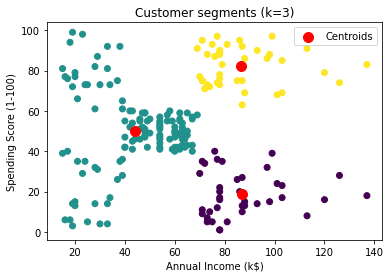

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=labels)
plt.scatter(means[:, 0], means[:, 1], s = 100, c = 'red', label = 'Centroids')
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title('Customer segments (k=3)')
plt.legend(loc="upper right")
plt.show()

In [26]:
means

tensor([[87.0000, 18.6316],
        [44.1545, 49.8293],
        [86.5385, 82.1282]])

### Comparing results of GMM and K-Means 
- Cluster means from GMM are:

       [[60.96636029, 55.95012326],
       [89.8152026 , 14.9613277 ],
       [48.76608998, 56.25559989]]
       
- Where as cluster means from  K-Means are:

        [[87.0000, 18.6316],
        [44.1545, 49.8293],
        [86.5385, 82.1282]]
        
- Therefore the Cluster means from GMM are very different from the cluster means we get from K-Means.
- Cluster interpretations changes at different executions. For the current execution the clusters are:
    - In GMM the cluster interpretations are:
        - Average Annual Income, Average Spending Score
        - Low Annual Income, High Spending Score
        - High Annual Income, low Spending Score
    - But in K-Means cluster interpretations are:
        - High Annual Income, low Spending Score
        - Average Annual Income, Average Spending Score
        - High Annual Income, High Spending Score
- Eventhough we get roughly the same interpretations, the resulting clusters of GMM and K-Means are different from one another.


### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [27]:
outlier = None
# YOUR CODE HERE
import numpy as np
import pandas as pd 
import scipy as stats

df = pd.DataFrame(X,columns=['income', 'spending'])
df.head()

def mahalanobis(x=None, data=None, cov=None):

    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

# Calculate Mahalanobis distance
df['mahalanobis_dis'] = mahalanobis(x=df, data=df[['income', 'spending']])

# Calculate p-value for each mahalanobis distance
df['p-value'] = 1 - chi2.cdf(df['mahalanobis_dis'], 3)

df.head()

,income,spending,mahalanobis_dis,p-value
0,15.0,39.0,3.182516,0.364332
1,15.0,81.0,4.472973,0.214714
2,16.0,6.0,5.751044,0.124371
3,16.0,77.0,3.990678,0.262472
4,17.0,40.0,2.893943,0.408268


In [28]:
outlier = df['p-value'] < 0.1

outlier 0      False
1      False
2      False
3      False
4      False
       ...  
195     True
196     True
197     True
198     True
199     True
Name: p-value, Length: 200, dtype: bool


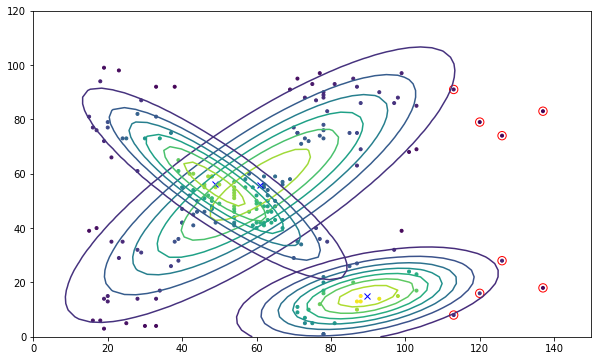

success!


In [29]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [30]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [31]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [32]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [33]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [34]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [35]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [36]:
# NOTE: 
# In the given code std is assigned to Mu and mean is assigned to Sigma which is on-correct
# when compared with Pandas Dataframe describe() method
# Threfore I commented the given code.

# Mu = np.std(data[numerical_colmns])
# Sigma = np.mean(data[numerical_colmns])
# print(Mu)
# print(Sigma)

In [37]:
data.describe()

,StockCode,Quantity,InvoiceDate,UnitPrice,Country,TotalSum
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,487.939600,10.941200,0.804000,3.252928,0.997000,22.146162
std,400.230701,146.559217,0.743569,5.908617,4.185128,65.908405
min,0.000000,-9360.000000,0.000000,0.030000,0.000000,-403.200000
25%,155.000000,1.000000,0.000000,1.250000,0.000000,3.750000
50%,392.000000,4.000000,1.000000,2.100000,0.000000,11.900000
75%,763.000000,12.000000,1.000000,3.750000,0.000000,19.800000
max,1471.000000,2880.000000,2.000000,295.000000,33.000000,1627.200000


In [38]:
# Corrected Sigma and Mu
Sigma = np.std(data[numerical_colmns])
Mu = np.mean(data[numerical_colmns])
print("===Mu===")
print(Mu)
print("===Sigma===")
print(Sigma)

===Mu===
Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64
===Sigma===
Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64


In [39]:
# Check for outliers

def cnt_outlier(data,sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(data,Sigma,Mu, numerical_colmns).sort_values(ascending=False)

UnitPrice    5
Quantity     0
TotalSum     0
dtype: int64

In [40]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [41]:
X = data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.60510319  0.66171654  1.5196613  -0.44643984  6.87883167  0.36263946]
 [-1.15038731  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]
 [-0.28784697  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]]


In [42]:
# Your code here

In [43]:
norm_df = pd.DataFrame(X[:,[1,3,5]],columns=['Quantity','UnitPrice', 'TotalSum'])
norm_df.head()

,Quantity,UnitPrice,TotalSum
0,-0.035724,-0.111638,-0.119495
1,-0.035724,0.020397,-0.050266
2,-0.023488,-0.080201,-0.027464
3,-0.035724,0.020397,-0.050266
4,-0.035724,0.020397,-0.050266


In [44]:
# NOTE :  Code obtained for  Nguyen Hanh's tutorial on Medium.com

from sklearn.mixture import GaussianMixture
from tqdm import tqdm as tqdm

def gmm_bic(a, lower=2, upper=10):
    bic = []
    for i in tqdm(range(lower,upper)):
        gm = GaussianMixture(n_components=i, covariance_type="full",max_iter=300, random_state=42)
        gm.fit(a)
        b = gm.bic(a)
        bic.append(b)
        print('Convergence? {} at iteration {}'.format(gm.converged_, gm.n_iter_))
    plt.plot(range(lower,upper), bic, 'bx-')

 50%|█████     | 4/8 [00:00<00:00, 27.47it/s]

Convergence? True at iteration 4
Convergence? True at iteration 4
Convergence? True at iteration 12
Convergence? True at iteration 12
Convergence? True at iteration 21


 88%|████████▊ | 7/8 [00:00<00:00, 10.56it/s]

Convergence? True at iteration 41
Convergence? True at iteration 21


100%|██████████| 8/8 [00:00<00:00,  8.10it/s]

Convergence? True at iteration 63


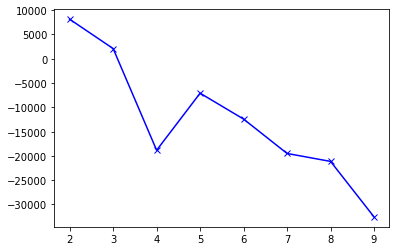

In [45]:
gmm_bic(norm_df)

#### Note : According to the graph optimal number of clusters = 4

- Therefore for GMM I select k = 4

In [46]:
# GMM 

gmm = GaussianMixture(n_components=4, max_iter=500, random_state=42)
gmm.fit(norm_df)
norm_df['Segment'] = gmm.predict(norm_df)
norm_df['Segment'].value_counts()

0    2580
1     967
3     465
2       1
Name: Segment, dtype: int64

In [47]:
outlier = None

def mahalanobis(x=None, data=None, cov=None):
    x_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

# Calculate Mahalanobis distance
norm_df['mahalanobis_dis'] = mahalanobis(x=norm_df[['Quantity','UnitPrice', 'TotalSum']], data=norm_df[['Quantity','UnitPrice', 'TotalSum']])

# Calculate p-value for each mahalanobis distance
norm_df['p-value'] = 1 - chi2.cdf(norm_df['mahalanobis_dis'], 4)

norm_df.head()

,Quantity,UnitPrice,TotalSum,Segment,mahalanobis_dis,p-value
0,-0.035724,-0.111638,-0.119495,0,0.024320,0.999927
1,-0.035724,0.020397,-0.050266,0,0.003624,0.999998
2,-0.023488,-0.080201,-0.027464,0,0.007201,0.999994
3,-0.035724,0.020397,-0.050266,0,0.003624,0.999998
4,-0.035724,0.020397,-0.050266,0,0.003624,0.999998


In [48]:
outlier = norm_df['p-value'] < 0.1

In [49]:
outlier.value_counts()

False    3944
True       69
Name: p-value, dtype: int64

### Discussion:
- In the first part of this exercise we found the outliers by univariate analysis using the normal distribution.
    - According to the univariate analysis, we get **5 outliers for UnitPrice only**. We could not observe any outliers for Quantity and TotalSum.
    - But when we analyze the `Dataframe` using the `describe()` method we get an idea that there could be outliers in Quantity and TotalSum features as well. But these are not found by our univariate analysis.
    
- In the second part of the exercise I try to find the optimal number of clusters by plotting likelihood as a function of  𝑘. And from the plot, we can observe an "elbow" when k = 4. Thus as the **optimal number of clusters, 4** is selected.

- Next, I developed the GMM method to find the 4 clusters.

- Further, I calculated the Mahalanobis distance for each sample which allows us to identify multi-variate outliers.
    - Once the Mahalanobis distances are obtained p-value for Mahalanobis distances was calculated using the Chi-square function.
    - I selected the threshold p-value as 0.1 and all samples with a p-value < 0.1 are categorized as outliers.
    - This resulted in **69 outlier data samples**, which were unable to detect in univariate outlier detection.
